In [1]:
using Distributions
using LinearAlgebra
using Plots
using Random

# Gradient Descent with Barzilai-Borwein Step Sizes

In [2]:
function grad(f,x;δ=1.0e-6)
    n = length(x)
    ∇fx = zeros(n)
    for i in 1:n
        e_l = zeros(n)
        e_r = zeros(n)
        e_l[i] = -δ
        e_r[i] = δ
        x_l = x+e_l
        x_r = x+e_r
        ∇fx[i] = (f(x_r)-f(x_l))/(2*δ)
    end
    return ∇fx
end

function hess(f,x;δ1=1.0e-8,δ2=1.0e-4)
    n = length(x)
    Hfx = zeros(n,n)
    for i in 1:n
        for j in i:n
            e_l = zeros(n)
            e_r = zeros(n)
            e_l[j] = -δ2
            e_r[j] = δ2
            x_l = x+e_l
            x_r = x+e_r
            ∇fx_l = grad(f,x_l,δ=δ1)
            ∇fx_r = grad(f,x_r,δ=δ1)
            Hfx[i,j] = (∇fx_r[i]-∇fx_l[i])/(2*δ2)
            Hfx[j,i] = Hfx[i,j]
        end
    end
    return Hfx
end

hess (generic function with 1 method)

In [3]:
function minimize_gd(f,x0;bb=true,γ=1.0e-1,tol=1.0e-8,maxiter=100000)
    n = length(x0)
    x_curr = x0
    ∇fx_curr = grad(f,x0)
    x_next = x_curr-γ*∇fx_curr
    x_list = zeros(0)
    append!(x_list,x_curr)
    append!(x_list,x_next)
    x_prev = x_curr
    x_curr = x_next
    iter = 1
    while (maximum(abs.(x_curr-x_prev)) > tol)
        γ_curr = dot(x_curr-x_prev,grad(f,x_curr)-grad(f,x_prev))/(norm(grad(f,x_curr)-grad(f,x_prev))^2)
        ∇fx_curr = grad(f,x_curr)
        if bb
            x_next = x_curr-γ_curr*∇fx_curr
        else
            x_next = x_curr-γ*∇fx_curr
        end
        append!(x_list,x_next)
        x_prev = x_curr
        x_curr = x_next
        iter = iter+1
        if (iter == maxiter)
            print("MAX ITERATIONS REACHED\n")
            m = length(x_list)
            x_list = reshape(x_list,(n,Int(m/n)))
            return x_curr, x_list
        end
    end
    m = length(x_list)
    x_list = reshape(x_list,(n,Int(m/n)))
    return x_curr, x_list
end

minimize_gd (generic function with 1 method)

## Example 1: Solving a Linear System

In [4]:
Random.seed!(1)

n = 5
A = rand(n,n)
b = rand(n)

function f1(x;A=A,b=b)
    return norm(A*x-b)^2
end

f1 (generic function with 1 method)

### Barzilai-Borwein Step Sizes

In [5]:
x_opt, x_list = minimize_gd(f1,ones(n))
print("x_opt: ",x_opt,"\n")
print("f_opt: ",f1(x_opt),"\n")
print("iters: ",size(x_list)[2])

x_opt: [5.393017880077939, -4.64600643524526, 0.38442860500428894, -0.8789630127675648, 4.192060361575541]
f_opt: 6.062884464796473e-15
iters: 117

In [6]:
inv(A)*b

5-element Array{Float64,1}:
  5.393018357208054
 -4.646007051647182
  0.38442860632281584
 -0.8789630684036798
  4.192060933653786

The output matches the analytical solution.

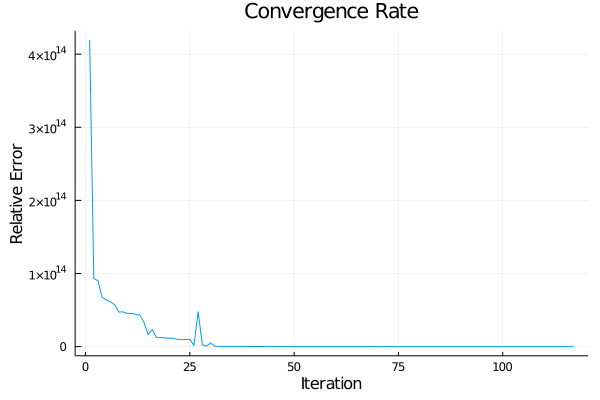

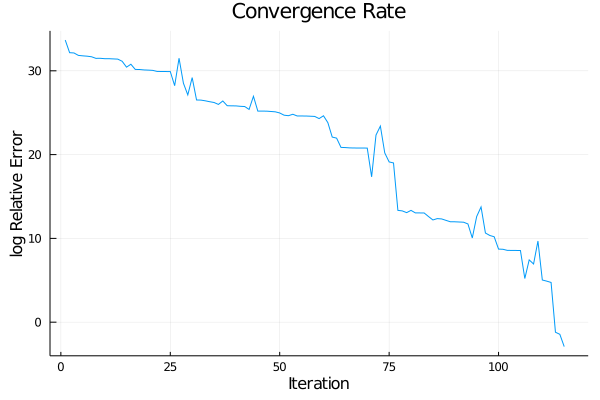

In [7]:
conv = zeros(size(x_list)[2])
for i in 1:length(conv)-1
    conv[i] = abs((f1(x_list[:,i+1])-f1(x_opt))/f1(x_opt))
end
display(plot(conv,title="Convergence Rate",xlabel="Iteration",ylabel="Relative Error",label=:false))
display(plot(log.(conv),title="Convergence Rate",xlabel="Iteration",ylabel="log Relative Error",label=:false))

### Fixed Step Sizes

In [8]:
x_opt, x_list = minimize_gd(f1,ones(n);bb=false,γ=0.1)
print("x_opt: ",x_opt,"\n")
print("f_opt: ",f1(x_opt),"\n")
print("iters: ",size(x_list)[2])

x_opt: [5.393011577448901, -4.645999045261118, 0.3844285386010368, -0.8789622153822443, 4.192053646111286]
f_opt: 1.0212543687554666e-12
iters: 10683

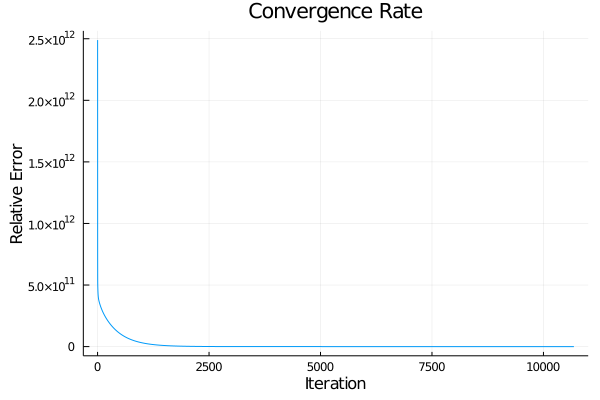

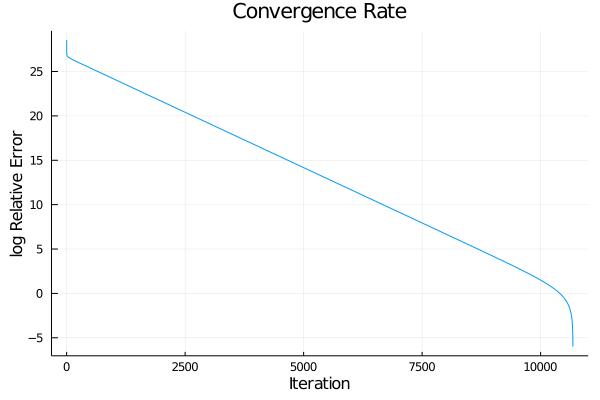

In [9]:
conv = zeros(size(x_list)[2])
for i in 1:length(conv)-1
    conv[i] = abs((f1(x_list[:,i+1])-f1(x_opt))/f1(x_opt))
end
display(plot(conv,title="Convergence Rate",xlabel="Iteration",ylabel="Relative Error",label=:false))
display(plot(log.(conv),title="Convergence Rate",xlabel="Iteration",ylabel="log Relative Error",label=:false))

## Example 2: Regularized Exponential

We minimize the convex function $f(x) = \exp(c^\top x)+\|x\|^2$.

In [10]:
Random.seed!(1)

n = 5
c = rand(-10:10,n)

function f2(x;c=c)
    return exp(dot(c,x))+norm(x)^2
end

f2 (generic function with 1 method)

### Barzilai-Borwein Step Sizes

In [11]:
x_opt, x_list = minimize_gd(f2,ones(n))
print("x_opt: ",x_opt,"\n")
print("f_opt: ",f2(x_opt),"\n")
print("iters: ",size(x_list)[2])

x_opt: [0.05219925630322789, 0.13919801644783533, -0.17399752006978061, 0.0695990083323569, 0.034799504273999235]
f_opt: 0.09323051866401993
iters: 24

To verify that this is correct, note that by convexity,

\begin{equation*}
    \frac{\partial f}{\partial x_i} = c_i \cdot \exp(c^\top x) + 2x_i = 0 \implies x^\star = -\frac{\exp(c^\top x^\star)}{2} \cdot c
\end{equation*}

In [12]:
-(exp(dot(c,x_opt))/2)*c

5-element Array{Float64,1}:
  0.052199256110101094
  0.13919801629360293
 -0.17399752036700367
  0.06959900814680146
  0.03479950407340073

The output matches the analytical solution.

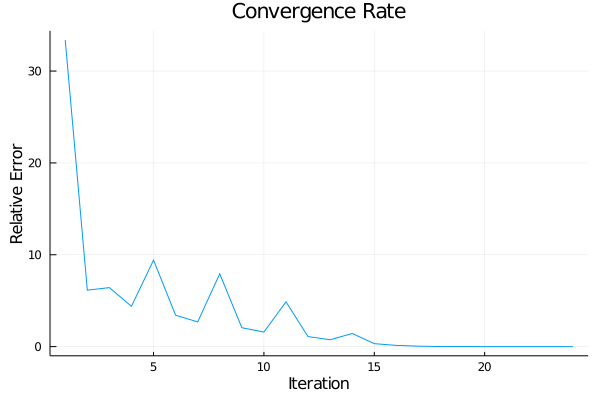

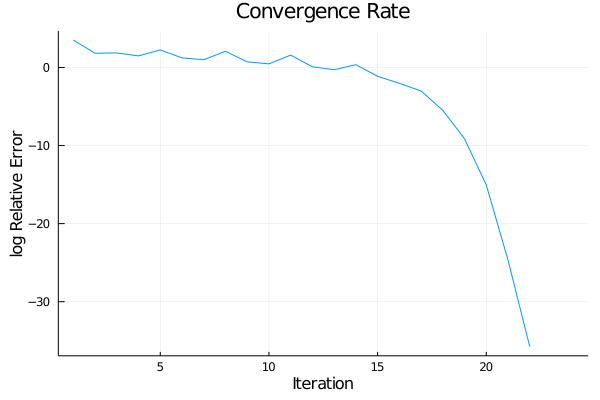

In [13]:
conv = zeros(size(x_list)[2])
for i in 1:length(conv)-1
    conv[i] = abs((f2(x_list[:,i+1])-f2(x_opt))/f2(x_opt))
end
display(plot(conv,title="Convergence Rate",xlabel="Iteration",ylabel="Relative Error",label=:false))
display(plot(log.(conv),title="Convergence Rate",xlabel="Iteration",ylabel="log Relative Error",label=:false))

### Fixed Step Sizes

In [14]:
x_opt, x_list = minimize_gd(f2,ones(n),bb=false,γ=0.1)
print("x_opt: ",x_opt,"\n")
print("f_opt: ",f2(x_opt),"\n")
print("iters: ",size(x_list)[2])

x_opt: [0.052199280712149854, 0.13919803588777113, -0.17399748274793492, 0.06959903174935578, 0.03479952967355615]
f_opt: 0.09323051866402354
iters: 79

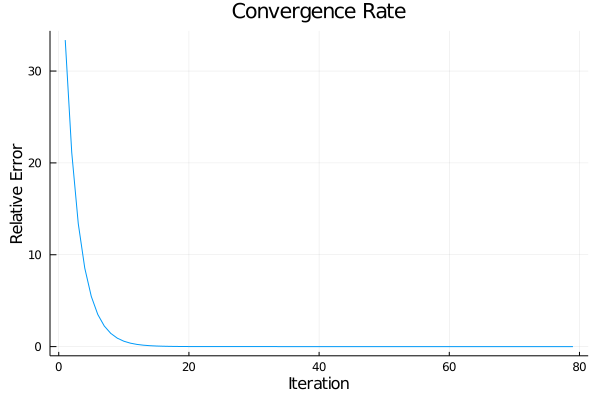

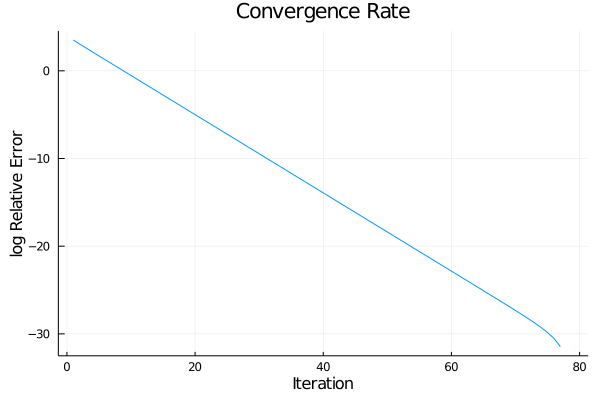

In [15]:
conv = zeros(size(x_list)[2])
for i in 1:length(conv)-1
    conv[i] = abs((f2(x_list[:,i+1])-f2(x_opt))/f2(x_opt))
end
display(plot(conv,title="Convergence Rate",xlabel="Iteration",ylabel="Relative Error",label=:false))
display(plot(log.(conv),title="Convergence Rate",xlabel="Iteration",ylabel="log Relative Error",label=:false))

## Backup

In [16]:
function gradf(f,args,x;δ=1.0e-6)
    n = length(x)
    ∇fx = zeros(n)
    for i in 1:n
        e_l = zeros(n)
        e_r = zeros(n)
        e_l[i] = -δ
        e_r[i] = δ
        x_l = x+e_l
        x_r = x+e_r
        ∇fx[i] = (f(x_r,args...)-f(x_l,args...))/(2*δ)
    end
    return ∇fx
end

function hessf(f,args,x;δ1=1.0e-8,δ2=1.0e-4)
    n = length(x)
    Hfx = zeros(n,n)
    for i in 1:n
        for j in i:n
            e_l = zeros(n)
            e_r = zeros(n)
            e_l[j] = -δ2
            e_r[j] = δ2
            x_l = x+e_l
            x_r = x+e_r
            ∇fx_l = gradf(f,args,x_l,δ=δ1)
            ∇fx_r = gradf(f,args,x_r,δ=δ1)
            Hfx[i,j] = (∇fx_r[i]-∇fx_l[i])/(2*δ2)
            Hfx[j,i] = Hfx[i,j]
        end
    end
    return Hfx
end

hessf (generic function with 1 method)